In [7]:
import cv2
import glob
import numpy as np
import time
import pickle
from skimage.feature import hog
from random import randint

import matplotlib
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from lesson_functions import bin_spatial, color_hist, get_hog_features, show_image

color_space = 'YCrCb' #RGB, HSV, HLS, LUV, YUV, YCrCb
spatial_size = (16, 16) #(32, 32)
hist_bins = 32
orient = 9
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

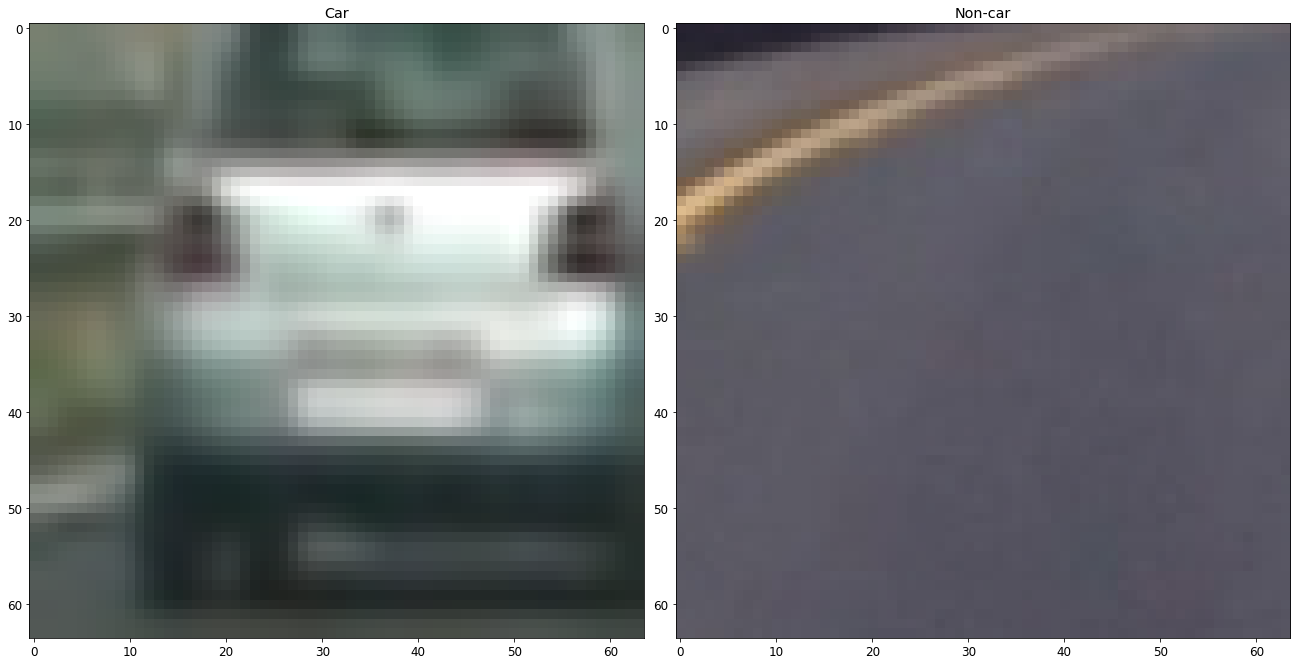

In [8]:
def load_image_path():
    cars = glob.glob("training_data/vehicles/**/*.png", recursive=True)
    notcars = glob.glob("training_data/non-vehicles/**/*.png", recursive=True)
    return cars, notcars

cars, notcars = load_image_path()
img_show_list = [mpimg.imread(cars[100]), mpimg.imread(notcars[100])]
lbl_show_list = ['Car', 'Non-car']
show_image(img_show_list, lbl_show_list)

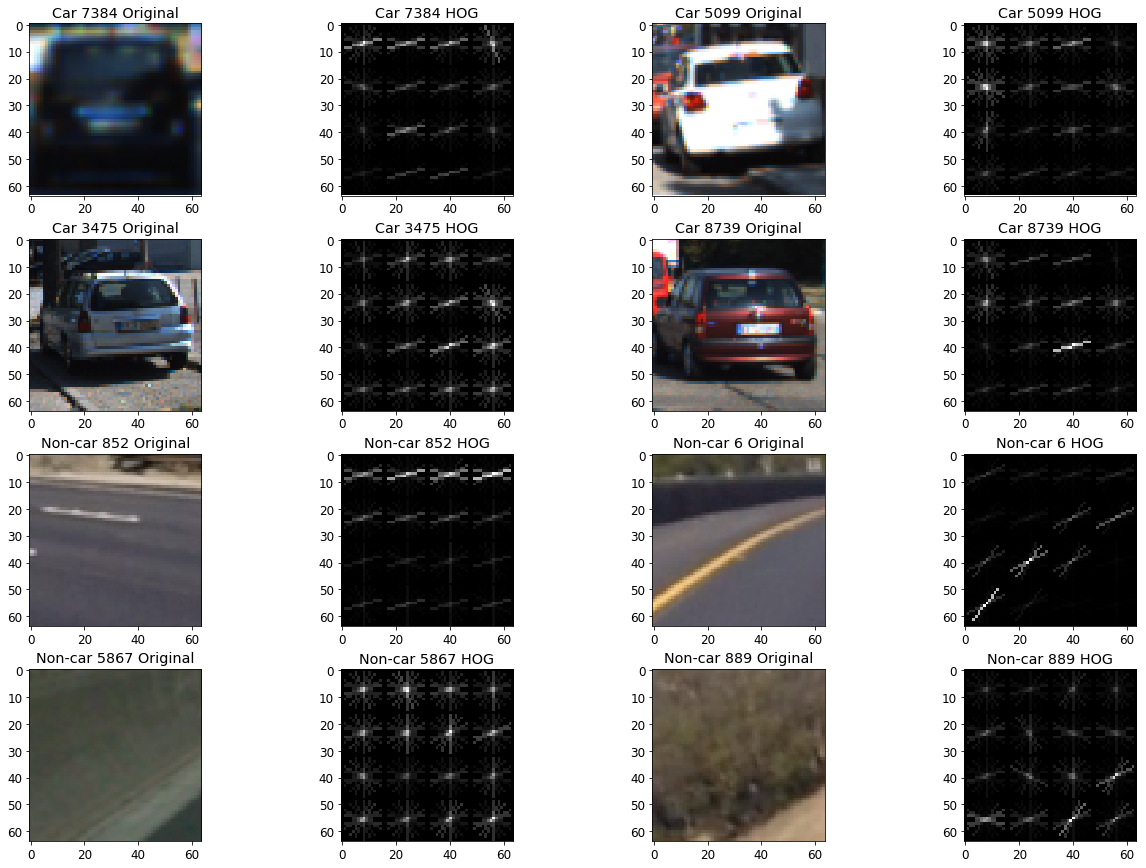

In [9]:
# Define a function to return HOG features and visualization
def get_hog_features(img, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  block_norm='L2-Hys',
                                  visualise=vis,
                                  feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       block_norm='L2-Hys',
                       visualise=vis, 
                       feature_vector=feature_vec)
        return features

def show_hog_sample():
    img_show_list = []
    lbl_show_list = []
    list_name = 'Car'

    for listx in load_image_path():

        for i in range(0, 4):
            rnd = randint(0, len(listx))
            img_src = mpimg.imread(listx[rnd])
            img_show_list.append(img_src)
            lbl_show_list.append('{} {} Original'.format(list_name, rnd))
            img_ycr = cv2.cvtColor(img_src, cv2.COLOR_RGB2YCrCb)

            hog_feature, hog_image = get_hog_features(img_ycr[:, :, -1], vis=True)
            img_show_list.append(hog_image)
            lbl_show_list.append('{} {} HOG'.format(list_name, rnd))
        list_name = 'Non-car'
    show_image(img_show_list, lbl_show_list, cols=4)

show_hog_sample()

In [10]:
def extract_features(image_file_list, hist_range=None, debug=False):

    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file_path in image_file_list:
        file_features = []
        img_src = mpimg.imread(file_path) # Read in each one by one

        if color_space != 'RGB': # apply color conversion if other than 'RGB'
            if color_space == 'HSV':
                img_feature = cv2.cvtColor(img_src, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                img_feature = cv2.cvtColor(img_src, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                img_feature = cv2.cvtColor(img_src, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                img_feature = cv2.cvtColor(img_src, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                img_feature = cv2.cvtColor(img_src, cv2.COLOR_RGB2YCrCb)
        else:
            img_feature = np.copy(img_src)

        # Spatial feature
        feature_spatial = bin_spatial(img_feature, size=spatial_size)
        file_features.append(feature_spatial)

        # color hist feature
        if hist_range is None:
            feature_color_hist = color_hist(img_feature, nbins=hist_bins)
        else:
            feature_color_hist = color_hist(img_feature, nbins=hist_bins, bins_range=hist_range)
        file_features.append(feature_color_hist)

        # Hog feature with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            feature_hog_list = []
            for channel in range(img_feature.shape[2]):
                feature_hog_list.append(get_hog_features(img_feature[:, :, channel], vis=False, feature_vec=True))
            feature_hog_list = np.ravel(feature_hog_list)
        else:
            feature_hog_list = get_hog_features(img_feature[:, :, hog_channel], vis=False, feature_vec=True)

        file_features.append(feature_hog_list)
        features.append(np.concatenate(file_features))

    return features

In [11]:
def train_classifier(debug=False, vis=False):
    cars, notcars = load_image_path()
    if debug:
        print("Extracting features from {} car images".format(len(cars)))
    features_car = extract_features(cars, debug=debug)
    if debug:
        print('Done extracting car features.')

    if debug:
        print("Extracting features from {} non-car images".format(len(notcars)))

    features_noncar = extract_features(notcars, debug=debug)
    if debug:
        print('Done extracting non-car features.')

    X = np.vstack((features_car, features_noncar)).astype(np.float64)  # Array stack of feature vectors
    X_scaler = StandardScaler().fit(X)  # Fit a per-column scaler

    scaled_X = X_scaler.transform(X)  # Apply the scaler to X
    y = np.hstack((np.ones(len(features_car)), np.zeros(len(features_noncar))))  # Define the labels vector

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

    if debug:
        print('Random state   :', rand_state)
        print('Training size  :', len(y_train))
        print('Test size      :', len(y_test))

    svc = LinearSVC(loss='hinge')

    # Check the training time for the SVC
    t = time.time()
    if debug:
        print("Start training")
    svc.fit(X_train, y_train)
    accuracy_svc = svc.score(X_test, y_test)
    t2 = time.time()
    if debug:
        print('Training time  : {}s'.format(round(t2 - t, 2)))
        print('-' * 27)
        print('Prediction accuracy: {:.4f}'.format(accuracy_svc))
        print('-' * 27)

    # Persist some data for later use
    if debug:
        print("Model file: training_data.p")

    with open(b"training_data.p", "wb") as f:
        training_data = {
            'cell_per_block': cell_per_block,
            'color_space': color_space,
            'hist_bins': hist_bins,
            'hog_channel': hog_channel,
            'pix_per_cell': pix_per_cell,
            'orient': orient,
            'spatial_size': spatial_size,
            'svc': svc,
            'X_scaler': X_scaler,
        }
        pickle.dump(training_data, f)

    # Check the prediction time for 10 samples
    pred_sample_size = 10
    pred_result = svc.predict(X_test[:pred_sample_size])

    if debug:
        print('Prediction :', pred_result)
        print('Data Labels:', y_test[:pred_sample_size])

    return svc, accuracy_svc

In [12]:
train_classifier(debug=True)

Extracting features from 8792 car images
Done extracting car features.
Extracting features from 8968 non-car images
Done extracting non-car features.
Random state   : 15
Training size  : 14208
Test size      : 3552
Start training
Training time  : 5.41s
---------------------------
Prediction accuracy: 0.9828
---------------------------
Model file: training_data.p
Prediction : [ 1.  0.  0.  0.  1.  0.  0.  1.  1.  0.]
Data Labels: [ 1.  0.  0.  0.  1.  0.  0.  1.  1.  0.]


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
      penalty='l2', random_state=None, tol=0.0001, verbose=0),
 0.98282657657657657)